In [1]:
import numpy as np
import tifffile as tf
import ntpath
import fnmatch
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import time
import math
from utils.paq2py import *
from utils.parse_markpoints import ParseMarkpoints
from utils.utils_funcs import *
import seaborn as sns
from random import randint
from scipy import stats
import csv

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
sns.set()
sns.set_style('white')
%matplotlib notebook

In [2]:
#the path to your paq file
paq_path = r"C:\Users\roble\Documents\Packer lab\TempData\Finding targeted cells\2019-04-25_RL035_t-005.paq"
#the path to the umbrella suite2p file
s2p_path = r'C:\Users\roble\Documents\Packer lab\TempData\Finding targeted cells'
#the path to your naparm folder with FOVTarget files
naparm_path = r'C:\Users\roble\Documents\Packer lab\TempData\Finding targeted cells\2019-04-25_RL035_NAPARM_005'
#the path to your opsin expression file
opsin_path = r"C:\Users\roble\Documents\Packer lab\TempData\Finding targeted cells\2019-04-25_RL035_s-005_Cycle00001_Ch2_000001.ome.tif"

#change this to the name of the paq channel that the stim times was recorded on
stim_name = 'markpoints2packio'

In [3]:
paq = paq_read(paq_path)
raw, stat = s2p_loader(s2p_path, subtract_neuropil=True)

arr = dfof(raw)
#arr = raw
num_units = arr.shape[0]

arr.shape

(66, 3287)

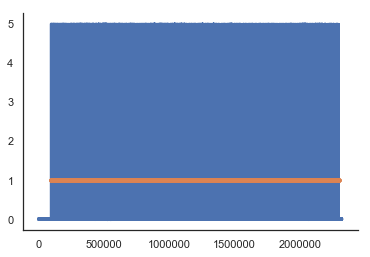

In [4]:
#you might need to run these cells twice to the get the plots for some reason

clock_idx = paq['chan_names'].index('frame_clock')
clock_voltage = paq['data'][clock_idx, :]

frame_clock = threshold_detect(clock_voltage, 1)
plt.figure()
plt.plot(clock_voltage)
plt.plot(frame_clock, np.ones(len(frame_clock)), '.')
sns.despine()
plt.show()

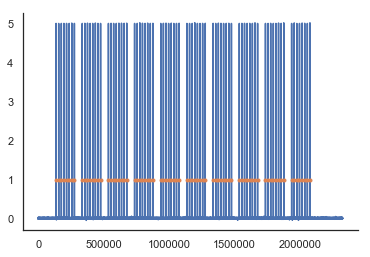

In [5]:
stim_idx = paq['chan_names'].index(stim_name)
stim_volts = paq['data'][stim_idx, :]
stim_times = threshold_detect(stim_volts, 1)
plt.figure()
plt.plot(stim_volts)
plt.plot(stim_times, np.ones(len(stim_times)), '.')
sns.despine()
plt.show()

In [6]:
#get mean intensity for each s2p unit from opsin expression image

opsin_image = tf.imread(opsin_path)

opsin_cell_intensities = []

for i,_ in enumerate(stat):
    y_pixels = stat[i]['ypix']
    x_pixels = stat[i]['xpix']
    
    intensity = []
    
    for y_index,x_index in zip(y_pixels, x_pixels):
        intensity.append(opsin_image[y_index][x_index])

    opsin_cell_intensities.append(np.mean(intensity))

C:\Users\roble\Anaconda3\lib\site-packages\tifffile\tifffile.py:8195: RuntimeWarning: invalid value encountered in true_divide
  'ZDistance': values[:, 0] / values[:, 1],


In [64]:
# work out how many groups in NAPARM from the targets folder + # of 'FOVTargets' files

# lookup recursive for NAPARM target images, find number of stim groups
num_groups = 0
pattern = 'FOVTargets*'
for dirpath, dirnames, filenames in os.walk(naparm_path):

    if not filenames:
        continue

    target_files = fnmatch.filter(filenames, pattern)
    if target_files:
        for i,file in enumerate(target_files):
            num_groups += 1
            print('{}\{}'.format(dirpath, file))
            target_files[i] = dirpath + '\\' + file

# separate stim_times in to groups (np.array?)
groups = np.arange(num_groups)
num_stims = len(stim_times)
num_trials = num_stims//num_groups

stim_times_grouped = np.zeros((num_groups, num_trials))

for i in groups:
    stim_times_grouped[i] = stim_times[i:num_stims:num_groups]

print(stim_times_grouped)

# load target images in loop and find pixels with 255 value, note xy indices for each
target_images = tf.imread(target_files)

targets = np.where(target_images == np.amax(target_images)) #indexed as group index, then y index, then x index
group_list = list(targets[0])
num_targets = []

for group in groups:
    num_targets.append(group_list.count(group))

#find roi xy values of cells from stat?
#compare roi xy values of each cell to all target cells and append index to a list of targeted cells if so
target_units = [[] for i in range(num_groups)]
target_indices = [[] for i in range(num_groups)]

for i,_ in enumerate(stat):
    y_pixels = stat[i]['ypix']
    x_pixels = stat[i]['xpix']
    
    for y_index,y_value in enumerate(targets[1]):
        x_value = targets[2][y_index]
        
        y_values = np.arange(y_value-7,y_value+7)
        x_values = np.arange(x_value-7,x_value+7)
        
        #if y_values in y_pixels and x_values in x_pixels:
        if any(y in y_pixels for y in y_values) and any(x in x_pixels for x in x_values): 
            group_index = targets[0][y_index]
            target_units[group_index].append(stat[i]['original_index'])
            target_indices[group_index].append(i)

print(target_units)
print(target_indices)

C:\Users\roble\Documents\Packer lab\TempData\Finding targeted cells\2019-04-25_RL035_NAPARM_005\Targets\FOVTargets_001_2019-04-25_RL035_NAPARM_005.tif
C:\Users\roble\Documents\Packer lab\TempData\Finding targeted cells\2019-04-25_RL035_NAPARM_005\Targets\FOVTargets_002_2019-04-25_RL035_NAPARM_005.tif
C:\Users\roble\Documents\Packer lab\TempData\Finding targeted cells\2019-04-25_RL035_NAPARM_005\Targets\FOVTargets_003_2019-04-25_RL035_NAPARM_005.tif
C:\Users\roble\Documents\Packer lab\TempData\Finding targeted cells\2019-04-25_RL035_NAPARM_005\Targets\FOVTargets_004_2019-04-25_RL035_NAPARM_005.tif
C:\Users\roble\Documents\Packer lab\TempData\Finding targeted cells\2019-04-25_RL035_NAPARM_005\Targets\FOVTargets_005_2019-04-25_RL035_NAPARM_005.tif
C:\Users\roble\Documents\Packer lab\TempData\Finding targeted cells\2019-04-25_RL035_NAPARM_005\Targets\FOVTargets_006_2019-04-25_RL035_NAPARM_005.tif
C:\Users\roble\Documents\Packer lab\TempData\Finding targeted cells\2019-04-25_RL035_NAPARM_00

In [65]:
stim_start_frames = []

for stim in stim_times:

    #the index of the frame immediately preceeding stim
    stim_start_frame = next(i-1 for i,sample in enumerate(frame_clock) if sample - stim >= 0)
    stim_start_frames.append(stim_start_frame)
    
stim_start_frames = np.array(stim_start_frames)

#sanity check
assert max(stim_start_frames) < arr.shape[1]

stim_frames_grouped = np.empty((num_groups, num_trials))

for i in groups:
    stim_frames_grouped[i] = stim_start_frames[i:num_stims:num_groups]
    
stim_frames_grouped

array([[  62.,  360.,  659.,  958., 1257., 1555., 1854., 2153., 2452.,
        2750.],
       [  92.,  390.,  689.,  988., 1286., 1585., 1884., 2183., 2481.,
        2780.],
       [ 121.,  420.,  719., 1018., 1316., 1615., 1914., 2213., 2511.,
        2810.],
       [ 151.,  450.,  749., 1047., 1346., 1645., 1944., 2242., 2541.,
        2840.],
       [ 181.,  480.,  779., 1077., 1376., 1675., 1974., 2272., 2571.,
        2870.],
       [ 211.,  510.,  808., 1107., 1406., 1705., 2003., 2302., 2601.,
        2900.],
       [ 241.,  540.,  838., 1137., 1436., 1735., 2033., 2332., 2631.,
        2930.],
       [ 271.,  570.,  868., 1167., 1466., 1764., 2063., 2362., 2661.,
        2959.]])

In [71]:
#pick a group to analyse (indexing starts at 0)
#group_i = 0

#this is the key parameter for the sta, how many frames before and after the stim do you want to use
pre_frames = 30
post_frames = 30

#list of cell pixel intensity values during each stim on each trial
all_trials_grouped = []

# the average of every trial
stas_grouped = []

sta_amplitudes_grouped = []

t_tests_grouped = []
mann_whits_grouped = []

for group_i in groups:
    
    #list of cell pixel intensity values during each stim on each trial
    all_trials = []

    # the average of every trial
    stas = []

    sta_amplitudes = []
    
    t_tests = []
    mann_whits = []

    #loop through each cell
    for i, unit in enumerate(arr):

        trials = []
        df = []
        amplitudes = []

        # a flat list of all observations before stim occured
        pre_obs = []
        # a flat list of all observations after stim occured
        post_obs = []

        for stim in stim_frames_grouped[group_i]:
            stim = int(stim)
            #slice the trial pre stim vs post stim
            pre_stim  = unit[stim-pre_frames : stim]
            post_stim = unit[stim : stim + post_frames]

            # append to flat lists
            [pre_obs.append(ob) for ob in pre_stim]
            [post_obs.append(ob) for ob in post_stim]

            # the whole trial
            trial = unit[stim-pre_frames : stim+post_frames]
            trials.append(trial)

            #calc amplitude of response        
            pre_f = np.mean(pre_stim)
            post_f = np.mean(post_stim)
            amplitude = post_f - pre_f
            amplitudes.append(amplitude)

        all_trials.append(trials)

        #average amplitudes across trials
        all_amplitudes = np.array(amplitudes)
        sta_amplitude = np.mean(all_amplitudes,0)
        sta_amplitudes.append(sta_amplitude)

        #average across all trials
        sta = np.mean(trials, 0)        
        stas.append(sta)

        #remove nans from flat lists
        pre_obs = [x for x in pre_obs if ~np.isnan(x)]
        post_obs = [x for x in post_obs if ~np.isnan(x)]

        #t_test and man whit test pre and post stim (any other test could also be used here)
        t_test = stats.ttest_ind(pre_obs, post_obs)
        t_tests.append(t_test)

        mann_whit = stats.mannwhitneyu(pre_obs, post_obs)
        mann_whits.append(mann_whit)
    
    # the average of every trial
    stas_grouped.append(stas)
    
    # list of cell pixel intensity values during each stim on each trial
    all_trials_grouped.append(all_trials)   
    
    t_tests_grouped.append(t_tests)
    mann_whits_grouped.append(mann_whits)

    sta_amplitudes_grouped.append(sta_amplitudes)

stas_grouped = np.array(stas_grouped)
all_trials_grouped = np.array(all_trials_grouped)
sta_amplitudes_grouped = np.array(sta_amplitudes_grouped)
t_tests_grouped = np.array(t_tests_grouped)
mann_whits_grouped = np.array(mann_whits_grouped)

In [75]:
all_trials_grouped.shape

(8, 66, 10, 60)

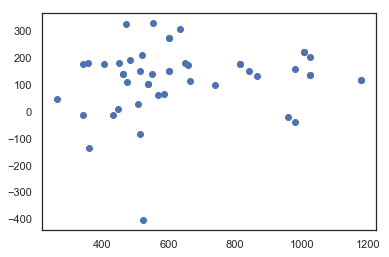

In [78]:
x_axis = []
y_axis = []

for group_i in groups:
    target_i = np.array(target_indices[group_i])

    for i in target_i:
        x_axis.append(opsin_cell_intensities[i])
        y_axis.append(sta_amplitudes_grouped[group_i,i])

plt.scatter(x_axis, y_axis)

In [69]:
#set this to true if you want to multiple comparisons correct for the number of cells
multi_comp_correction = True
if not multi_comp_correction: 
    divisor = 1
else:
    divisor = num_units

In [73]:
#choose group to analyse + plot
group_i = 0

p_vals = [t[1] for t in t_tests_grouped[group_i]]
idx = range(len(p_vals))

if multi_comp_correction:
    print('performing t-test on cells with mutliple comparisons correction')
else:
    print('performing t-test on cells without mutliple comparisons correction')
    
count = 0
sig_units = []
for p,i in sorted(zip(p_vals,idx)):
    if p < 0.05 / divisor:
        count += 1
        unit_index = stat[i]['original_index']
        if unit_index in target_units[group_i]: target_boolean = 'yes' 
        else: target_boolean = 'no' 
        print('Stim {} significantly changed fluoresence of s2p unit {}, its P value is {}. Target? {}'.format(group_i,unit_index, p, target_boolean))
        sig_units.append(i) #significant units

performing t-test on cells with mutliple comparisons correction
Stim 0 significantly changed fluoresence of s2p unit 217, its P value is 3.79870727678086e-133. Target? yes
Stim 0 significantly changed fluoresence of s2p unit 20, its P value is 1.4026908661102579e-132. Target? yes
Stim 0 significantly changed fluoresence of s2p unit 224, its P value is 1.545654142387866e-129. Target? yes
Stim 0 significantly changed fluoresence of s2p unit 21, its P value is 6.64095439799157e-110. Target? yes
Stim 0 significantly changed fluoresence of s2p unit 1, its P value is 3.2034309119810393e-99. Target? yes
Stim 0 significantly changed fluoresence of s2p unit 28, its P value is 1.8140089822928259e-88. Target? yes
Stim 0 significantly changed fluoresence of s2p unit 85, its P value is 1.4657990328517367e-67. Target? no
Stim 0 significantly changed fluoresence of s2p unit 47, its P value is 7.531670735638457e-42. Target? no
Stim 0 significantly changed fluoresence of s2p unit 299, its P value is 3.

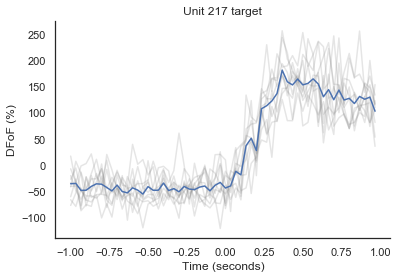

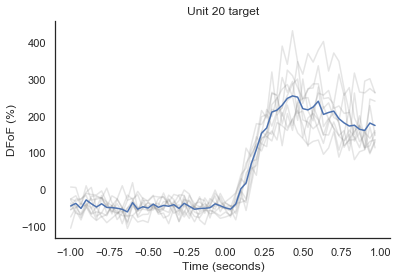

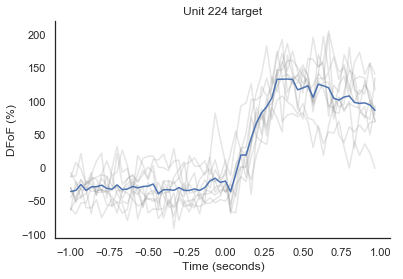

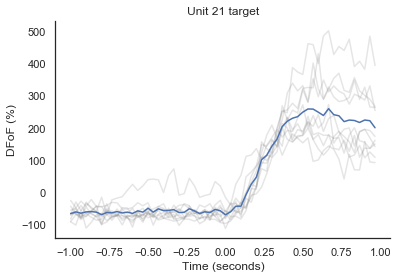

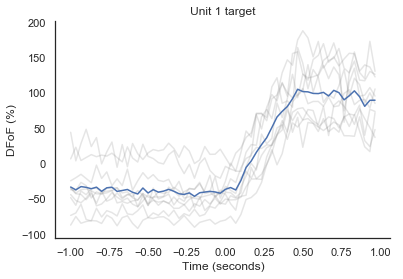

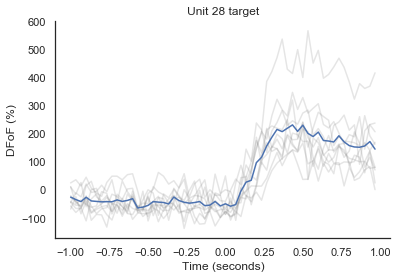

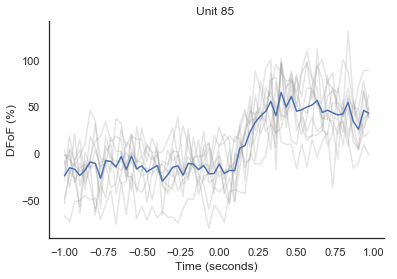

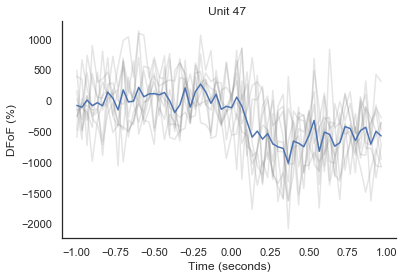

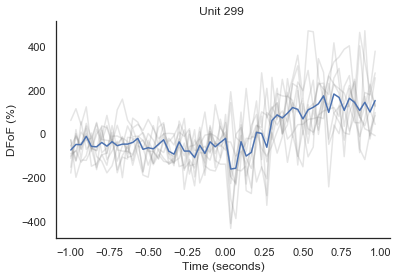

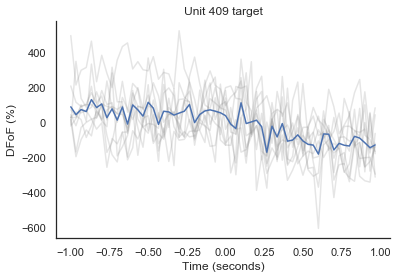

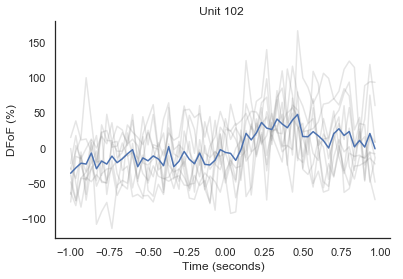

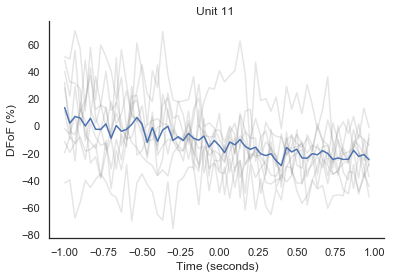

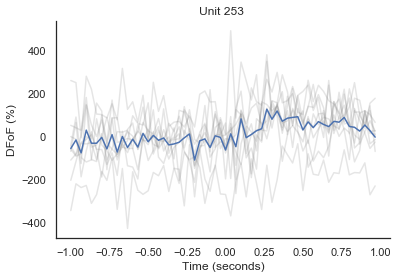

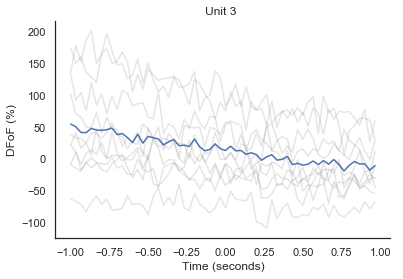

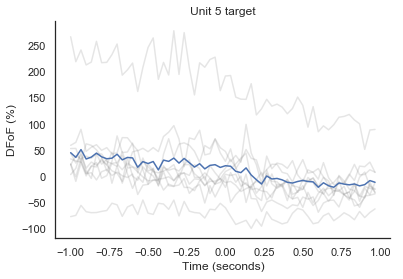

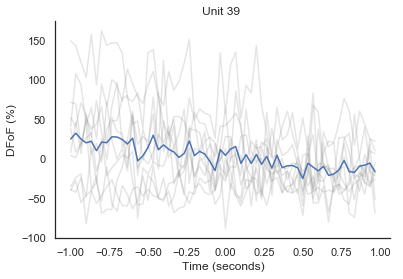

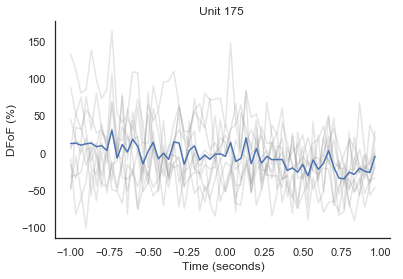

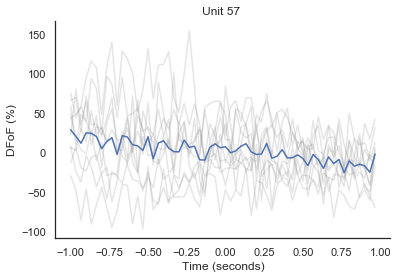

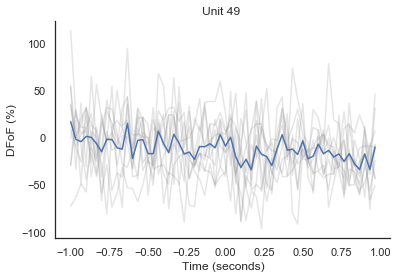

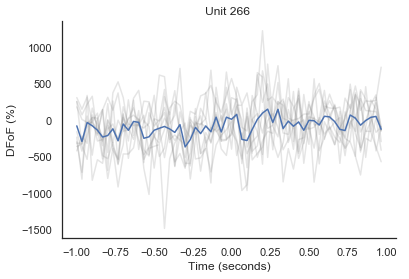

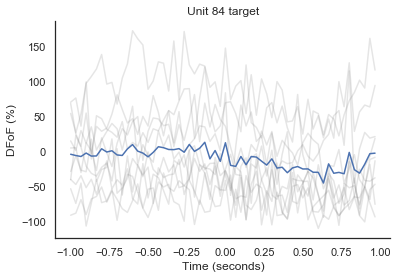

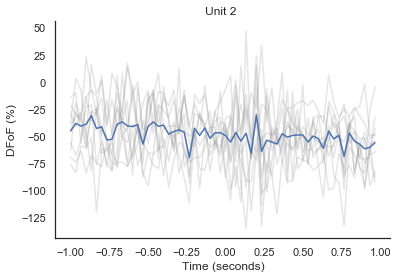

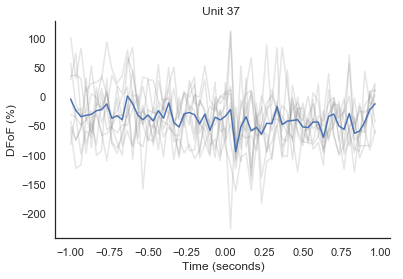

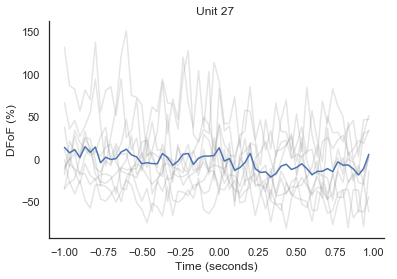

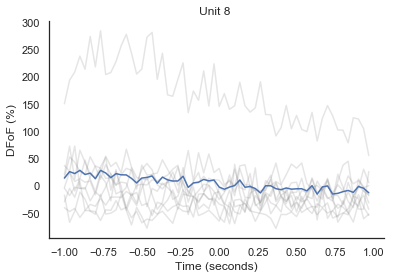

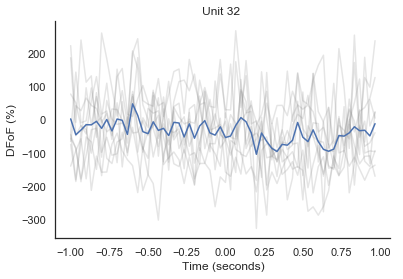

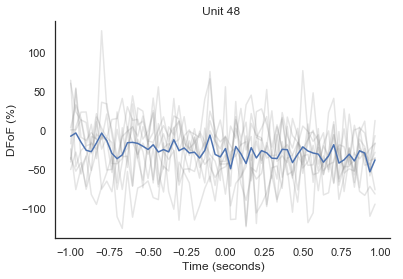

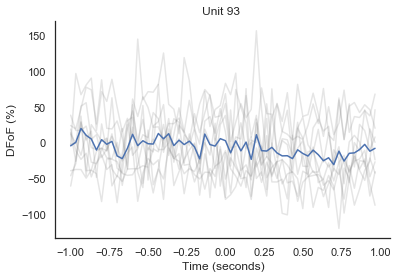

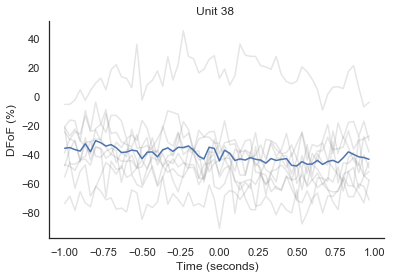

In [77]:
#set the unit number here you want to plot
for i in sig_units:
    unit = i
    unit_index = stat[i]['original_index']
    
    if unit_index in target_units[group_i]: 
        target_report = 'target' 
    else:
        target_report = ''
    
    frame_rate = 30
    x_axis = (np.arange(len(sta)) - pre_frames) / frame_rate

    plt.figure()

    sta = stas_grouped[group_i][unit]
    [plt.plot(x_axis, t, c='grey', alpha=0.2) for t in all_trials_grouped[group_i,unit,:,:]]
    plt.plot(x_axis, sta)
    plt.title('Unit ' + str(unit_index) + ' ' + target_report)
    plt.xlabel('Time (seconds)')
    plt.ylabel('DFoF (%)')
    #plt.ylim((-100,200))
    sns.despine()
    #plt.savefig('s2_responsive_cell.pdf')